# 🚗 Car Logo Recognition - AppliedML Assignment 4 

This notebook combines training, evaluation, quantization, and benchmarking for car logo recognition using ResNet18.



Team Members: 

👨‍💻 Rasmus Laitila / 23002 – Python Model Training

📱 Iiko Käki / 23001

☁️ Lauri Raatikainen / 23009 – Model Tuning and Report 






### Assignment

This project aims to build a model that can recognize car brands by identifying logos in images utulizing pretrained ResNet18 model.

In this Assignment we: 

- Used Resnet for Object detection and created the model

- Selected the model architecture (ResNet18) 

- Collected and prepared the dataset (https://www.kaggle.com/datasets/volkandl/car-brand-logos/data) 

- Dataset Contained 7 different Car Brands with separated Testing and Training images. Around 4000 images with 700 for testing purposes

- Implement training, evaluation, and testing pipelines

#### 🔗 Original Guide 

Link to the original implementation guide: (https://docs.google.com/document/d/17fY9Y_dCRo4ddwSaHfGfE0Ix-x4IcquIgM_br13_c70/edit?tab=t.0#heading=h.td1oyk4ob4ja)

### 🔗 GitHub Repository: 

Link to our GitHub Repo containing all the codes, including this Final Notebook: (https://github.com/RasmusLaitilaHAMK/OpenML)

## Training

In [13]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import random
import numpy as np

import os

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(5)  # Pick any number

# Paths
train_dir = 'CarLogoDataset/Train'
test_dir = 'CarLogoDataset/Test'

# Define transforms (resize and normalize)
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


# Load datasets
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=16, num_workers=2)

class_names = train_data.classes

# Get class count and names
num_classes = len(train_data.classes)
class_names = train_data.classes
print("Classes:", class_names)

# Load ResNet18 with pretrained weights
model = models.resnet18(progress=True, weights='DEFAULT')
print("Load Model")

# Replace final layer to match your classes
model.fc = nn.Linear(model.fc.in_features, len(class_names))
model = model.to(device)

print("Load Model part 2")

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

print("Loss function and optimizer, before training loop")

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")
print("After training loop")

# Evaluate
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

# Save model and class names
torch.save({
    'model_state_dict': model.state_dict(),
    'class_names': class_names
}, 'car_logo_model.pth')

Classes: ['hyundai', 'mazda', 'mercedes', 'opel', 'skoda', 'toyota', 'volkswagen']
Load Model
Load Model part 2
Loss function and optimizer, before training loop
Epoch 1/10 - Loss: 0.8052
Epoch 2/10 - Loss: 0.4492
Epoch 3/10 - Loss: 0.4078
Epoch 4/10 - Loss: 0.3756
Epoch 5/10 - Loss: 0.3212
Epoch 6/10 - Loss: 0.3217
Epoch 7/10 - Loss: 0.3038
Epoch 8/10 - Loss: 0.2890
Epoch 9/10 - Loss: 0.2851
Epoch 10/10 - Loss: 0.2409
After training loop
Test Accuracy: 86.57%


## Testing model and getting the Metrics

Simple testing with the Model for the Metrics, with and without tuning

In [14]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import random
import numpy as np

import os

import os, time
from pathlib import Path


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cpu


In [15]:

train_dir = 'CarLogoDataset/Train'
test_dir = 'CarLogoDataset/Test'

train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder(train_dir, transform=train_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)
class_names = train_data.classes
num_classes = len(class_names)


In [16]:

print("Evaluating pretrained model without fine-tuning")
model2_ckpt = torch.load('car_logo_model2.pth', map_location=device)
model2 = models.resnet18()
model2.fc = nn.Linear(model2.fc.in_features, len(model2_ckpt['class_names']))
model2.load_state_dict(model2_ckpt['model_state_dict'])
model2 = model2.to(device)
model2.eval()

correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model2(images)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

pre_finetune_acc = 100 * correct / total
print(f"Test Accuracy (Pre-trained, Not Fine-tuned): {pre_finetune_acc:.2f}%")


Evaluating pretrained model without fine-tuning
Test Accuracy (Pre-trained, Not Fine-tuned): 13.71%


In [17]:

print("Evaluating fine-tuned model")
ckpt = torch.load('car_logo_model.pth', map_location=device)
model = models.resnet18()
model.fc = nn.Linear(model.fc.in_features, len(ckpt['class_names']))
model.load_state_dict(ckpt['model_state_dict'])
model = model.to(device)
model.eval()

correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

post_finetune_acc = 100 * correct / total
print(f"Test Accuracy (Fine-tuned): {post_finetune_acc:.2f}%")


Evaluating fine-tuned model
Test Accuracy (Fine-tuned): 86.57%


In [18]:

torch.save(model.state_dict(), 'model_fp32.pth')
fp32_size = os.path.getsize('model_fp32.pth') / 1e6
print(f"Model Size before Quantization: {fp32_size:.2f} MB")


Model Size before Quantization: 44.80 MB


In [19]:

quantized_model = torch.quantization.quantize_dynamic(
    model, {torch.nn.Linear}, dtype=torch.qint8
)
torch.save(quantized_model.state_dict(), 'model_int8.pth')
int8_size = os.path.getsize('model_int8.pth') / 1e6
print(f"Model Size after Quantization: {int8_size:.2f} MB")


Model Size after Quantization: 44.79 MB


In [20]:

quantized_model = torch.quantization.quantize_dynamic(
    model, {torch.nn.Linear}, dtype=torch.qint8
)
quantized_model.eval()
quantized_model.to(device)

correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = quantized_model(images)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

quantized_acc = 100 * correct / total
print(f"Test Accuracy after Quantization: {quantized_acc:.2f}%")


Test Accuracy after Quantization: 86.57%


In [21]:

def measure_latency(model, samples, device):
    model.eval()
    with torch.no_grad():
        start = time.time()
        for sample in samples:
            sample = sample.unsqueeze(0).to(device)
            model(sample)
        end = time.time()
    return (end - start) / len(samples) * 1000  # in milliseconds

# Sample images from test set
sample_imgs = [test_data[i][0] for i in np.random.choice(len(test_data), 10, replace=False)]


In [22]:

fp32_latency = measure_latency(model, sample_imgs, device)
int8_latency = measure_latency(quantized_model, sample_imgs, device)

print(f"Avg Inference Latency (FP32): {fp32_latency:.2f} ms")
print(f"Avg Inference Latency (INT8): {int8_latency:.2f} ms")


Avg Inference Latency (FP32): 55.07 ms
Avg Inference Latency (INT8): 42.08 ms


In [23]:

print("\nSummary of Metrics:")
print(f"1. Test Accuracy before Fine-tuning: {pre_finetune_acc:.2f}%")
print(f"2. Test Accuracy after Fine-tuning: {post_finetune_acc:.2f}%")
print(f"3. Model Size before Quantization: {fp32_size:.2f} MB")
print(f"4. Test Accuracy after Quantization: {quantized_acc:.2f}%")
print(f"5. Model Size after Quantization: {int8_size:.2f} MB")
print(f"6. Memory Saving after Quantization: {fp32_size - int8_size:.2f} MB")
print(f"7. Accuracy Drop after Quantization: {post_finetune_acc - quantized_acc:.2f}%")
print(f"8. Inference Latency FP32: {fp32_latency:.2f} ms | INT8: {int8_latency:.2f} ms")



Summary of Metrics:
1. Test Accuracy before Fine-tuning: 13.71%
2. Test Accuracy after Fine-tuning: 86.57%
3. Model Size before Quantization: 44.80 MB
4. Test Accuracy after Quantization: 86.57%
5. Model Size after Quantization: 44.79 MB
6. Memory Saving after Quantization: 0.01 MB
7. Accuracy Drop after Quantization: 0.00%
8. Inference Latency FP32: 55.07 ms | INT8: 42.08 ms


# Final Testing

We created a final testing phase where we gave the Model 3 images with different Car logos, each more complex and tested how the model would perform comparing the complexity of the different images. 

### Results
The difference was clear between the more and less complex images. Toyota image was complex where the Mercedes image was simple, and the difference was clearly visible for each Image. Volkswagen image proved that high Accuracy still makes it possible for wrong prediction.

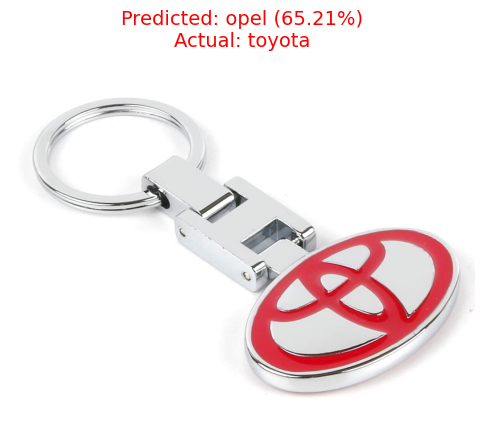

Image: 2r2r.jpg
  Actual label   : toyota
  Predicted label: opel (65.21%)



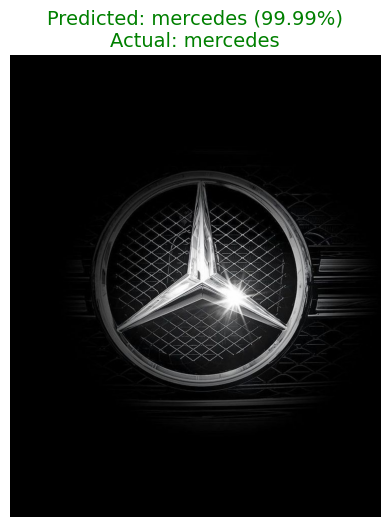

Image: mrc21.jpg
  Actual label   : mercedes
  Predicted label: mercedes (99.99%)



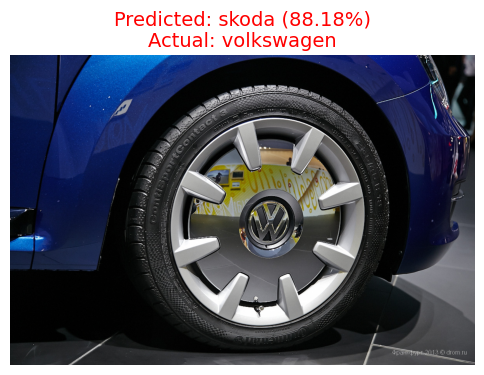

Image: 123123.jpg
  Actual label   : volkswagen
  Predicted label: skoda (88.18%)



In [27]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load model and class names
checkpoint = torch.load('car_logo_model.pth', map_location=device)

# Rebuild model
model = models.resnet18()
model.fc = torch.nn.Linear(model.fc.in_features, len(checkpoint['class_names']))
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

class_names = checkpoint['class_names']

# Image transform (same as training)
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# List of image paths (edit these as needed)
image_paths = [
    'CarLogoDataset/Test/toyota/2r2r.jpg',
    'CarLogoDataset/Test/mercedes/mrc21.jpg',
    'CarLogoDataset/Test/volkswagen/123123.jpg'
]

# Loop through the images
for img_path in image_paths:
    image = Image.open(img_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    true_label = os.path.basename(os.path.dirname(img_path)).lower()

    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        predicted_index = torch.argmax(probabilities).item()
        predicted_label = class_names[predicted_index]
        confidence = probabilities[predicted_index].item()

    # Visualization
    plt.figure(figsize=(6, 6))
    plt.imshow(np.array(image))
    plt.axis('off')
    title_color = 'green' if predicted_label.lower() == true_label else 'red'
    plt.title(
        f"Predicted: {predicted_label} ({confidence:.2%})\nActual: {true_label}",
        fontsize=14,
        color=title_color
    )
    plt.show()

    # Print summary
    print(f"Image: {os.path.basename(img_path)}")
    print(f"  Actual label   : {true_label}")
    print(f"  Predicted label: {predicted_label} ({confidence:.2%})\n")


## 🧾 Final Thoughts 


We successfully created a functioning car logo recognition app using ResNet18. Model accuracy improved significantly through tuning and testing. The assignment was interesting and fun, but lacked the time to develop a deeper understanding of the topic. Thank You!!!